In [1]:
import cv2
import numpy as np

In [3]:
def smooth(img, sigma=1.3, k=5):
    # 创建高斯核
    pad = k // 2
    guassian = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            guassian[i, j] = np.exp(-(i - pad) ** 2 / (2 * sigma ** 2) - (j - pad) ** 2 / (2 * sigma ** 2))
    guassian /= np.sum(guassian)  # 归一化高斯核

    # 对图像进行零填充
    H, W = img.shape
    padded_img = np.zeros((H + pad * 2, W + pad * 2))
    padded_img[pad:H + pad, pad:W + pad] = img

    # 应用高斯滤波
    new_img = np.zeros_like(img)
    for i in range(H):
        for j in range(W):
            new_img[i, j] = np.sum(padded_img[i:i + k, j:j + k] * guassian)

    return np.uint8(new_img)


In [4]:
def get_gradient_and_direction(img):
    sobelx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobely = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    H, W = img.shape
    gradients = np.zeros([H - 2, W - 2])
    directions = np.zeros([H - 2, W - 2])

    for i in range(H-2):
        for j in range(W-2):
            gx = np.sum(img[i:i+3, j:j+3] * sobelx)
            gy = np.sum(img[i:i+3, j:j+3] * sobely)
            gradients[i, j] = np.sqrt(gx ** 2 + gy ** 2)
            if gx == 0:
                directions[i, j] = np.pi / 2
            else:
                directions[i, j] = np.arctan(gy / gx)
    return np.uint8(gradients), directions

In [5]:
def NMS(gradients, direction):
    W, H = gradients.shape
    nms = np.copy(gradients[1:-1, 1:-1])

    for i in range(1, W - 1):
        for j in range(1, H - 1):
            theta = direction[i, j]
            weight = np.tan(theta)
            if theta > np.pi / 4:
                d1 = [0, 1]
                d2 = [1, 1]
                weight = 1 / weight
            elif theta >= 0:
                d1 = [1, 0]
                d2 = [1, 1]
            elif theta >= - np.pi / 4:
                d1 = [1, 0]
                d2 = [1, -1]
                weight *= -1
            else:
                d1 = [0, -1]
                d2 = [1, -1]
                weight = -1 / weight

            g1 = gradients[i + d1[0], j + d1[1]]
            g2 = gradients[i + d2[0], j + d2[1]]
            g3 = gradients[i - d1[0], j - d1[1]]
            g4 = gradients[i - d2[0], j - d2[1]]

            grade_count1 = g1 * weight + g2 * (1 - weight)
            grade_count2 = g3 * weight + g4 * (1 - weight)

            if grade_count1 > gradients[i, j] or grade_count2 > gradients[i, j]:
                nms[i - 1, j - 1] = 0

    return nms

In [6]:
def double_threshold(nms, threshold1, threshold2):
    visited = np.zeros_like(nms)
    output_image = nms.copy()
    W, H = output_image.shape

    def dfs(i, j):
        if i >= W or i < 0 or j >= H or j < 0 or visited[i, j] == 1:
            return
        visited[i, j] = 1
        if output_image[i, j] > threshold1:
            output_image[i, j] = 255
            dfs(i-1, j-1)
            dfs(i-1, j)
            dfs(i-1, j+1)
            dfs(i, j-1)
            dfs(i, j+1)
            dfs(i+1, j-1)
            dfs(i+1, j)
            dfs(i+1, j+1)
        else:
            output_image[i, j] = 0

    for w in range(W):
        for h in range(H):
            if visited[w, h] == 1:
                continue
            if output_image[w, h] >= threshold2:
                dfs(w, h)
            elif output_image[w, h] <= threshold1:
                output_image[w, h] = 0
                visited[w, h] = 1

    for w in range(W):
        for h in range(H):
            if visited[w, h] == 0:
                output_image[w, h] = 0
                
    return np.uint8(output_image)

In [7]:
img = cv2.imread("lena.jpg", 0)
smoothed_image = smooth(img)
gradients, direction = get_gradient_and_direction(smoothed_image)
nms = NMS(gradients, direction)
output_image = double_threshold(nms, 40, 100)

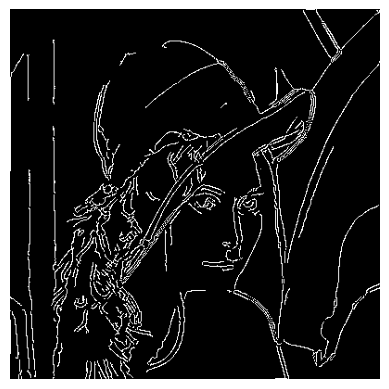

In [8]:
import matplotlib.pyplot as plt
plt.imshow(output_image, cmap='gray')
plt.axis('off')
plt.show()